<a href="https://colab.research.google.com/github/NBK-code/Normalizing_Flows_and_VAEs/blob/main/Normalizing_Flows_and_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normalizing Flows and Variational Autoencoders
## Introduction

This notebook is suppose to provide a fun exploration of normalizing flows and variational autoencoders. The notebook is divided into two parts. In the first part, we will create a synthetic image dataset with a normalizing flow generated by random parameters. The dataset comes from the contour plots of a transformed distribution. In the second part of the notebook, we will use the dataset to train a variational autoencoder and use the trained model to interpolate between the generated images. We will use concepts such as distribution objects, probabilistic layers, bijectors, ELBO optimisation and KL divergence regularisers.


First, we will import the neccessary libraries.

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Concatenate
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization

## Part-1 The Normalising Flow
* To construct the image dataset, we will build a normalising flow to transform a 2-D Gaussian random variable $z=(z_1, z_2)$, with mean $\mathbf{0}$ and covariance matrix $\Sigma=\sigma^2\mathbf{I}_2$, where $\sigma=0.3$. 
* This normalising flow uses bijectors that are parameterised by the following random variables:
  * $\theta \sim U[0, 2\pi)$
  * $a \sim N(3, 1)$
  
The complete normalising flow is given by the following chain of transformations:
* $f_1(z) = (z_1, z_2 - 2)$,
* $f_2(z) = (z_1, \frac{z_2}{2})$,
* $f_3(z) = (z_1, z_2 + az_1^2)$,
* $f_4(z) = Rz$, where $R$ is a rotation matrix with angle $\theta$,
* $f_5(z) = \tanh(z)$, where the $\tanh$ function is applied elementwise.

The transformed random variable $x$ is given by $x = f_5(f_4(f_3(f_2(f_1(z)))))$.

In [ ]:
#Base (Initial) Distribution

Initial_dist = tfd.MultivariateNormalDiag(loc = [[0.,0.]], scale_diag=[[0.3, 0.3]])

In [ ]:
# 𝑓_3(𝑧)=(𝑧_1,𝑧_2+𝑎𝑧_1^2) bijector

class alpha_bijector(tfb.Bijector):

  def __init__(self, alpha, validate_args = False, name = 'alpha'):
    super(alpha_bijector, self).__init__(validate_args = validate_args, 
                                         forward_min_event_ndims = 1, 
                                         name = name,
                                         is_constant_jacobian = True)
    self.alpha = alpha

  def _forward(self, z):
    z0 = tf.expand_dims(z[...,0], -1)
    z1 = tf.expand_dims(z[...,1], -1)
    x0 = z0
    x1 = z1 + self.alpha*z0**2
    return tf.concat([x0, x1], -1)

  def _inverse(self, x):
    x0 = tf.expand_dims(x[...,0], -1)
    x1 = tf.expand_dims(x[...,1], -1)
    z0 = x0
    z1 = x1 - self.alpha*x0**2
    return tf.concat([z0, z1], -1)

  def _forward_log_det_jacobian(self, z):
     return tf.constant(0.0, dtype = z.dtype)

  def _inverse_log_det_jacobian(self, x):
     return tf.constant(0.0, dtype = x.dtype)


In [ ]:
# 2D Rotation bijector

class Rotation2D(tfb.Bijector):

  def __init__(self, theta, validate_args = False, name = 'Rotation2D'):
    super(Rotation2D, self).__init__(validate_args = validate_args, 
                                     forward_min_event_ndims = 1, 
                                     name = name,
                                     is_constant_jacobian = True)
    self.theta = theta

  def _forward(self, z):
    z0 = tf.expand_dims(z[...,0], -1)
    z1 = tf.expand_dims(z[...,1], -1)
    x0 = np.cos(self.theta)*z0 - np.sin(self.theta)*z1
    x1 = np.sin(self.theta)*z0 + np.cos(self.theta)*z1
    return tf.concat([x0, x1], -1)    

  def _inverse(self, x):
    x0 = tf.expand_dims(x[...,0], -1)
    x1 = tf.expand_dims(x[...,1], -1)
    z0 = np.cos(self.theta)*x0 + np.sin(self.theta)*x1
    z1 = -np.sin(self.theta)*x0 + np.cos(self.theta)*x1
    return tf.concat([z0, z1], -1)

  def _forward_log_det_jacobian(self, z):
     return tf.constant(0.0, dtype = z.dtype)

  def _inverse_log_det_jacobian(self, x):
     return tf.constant(0.0, dtype = x.dtype)

In [ ]:
# Function to get samples of alpha and theta

def get_alpha_theta():

  normal = tfd.Normal(loc = 3, scale = 1)
  uniform = tfd.Uniform(low = 0.0, high = 2*np.pi)

  alpha = np.squeeze(normal.sample(1))
  theta = np.squeeze(uniform.sample(1))

  return alpha, theta

In [ ]:
# Function to get the transformed distribution

def get_Transformed_dist(alpha, theta): 

  bijectors = [tfb.Shift([0., -2]),
             tfb.Scale([1., 0.5]),
             alpha_bijector(alpha),
             Rotation2D(theta),
             tfb.Tanh()]

  complete_bijector = tfb.Chain(list(reversed(bijectors)))

  return tfd.TransformedDistribution(Initial_dist, complete_bijector)



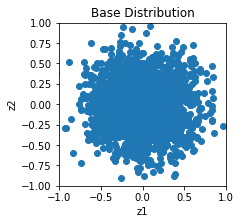

In [ ]:
# Scatter plot of base distribution

z = Initial_dist.sample(2000)
z0 = z[...,0]
z1 = z[...,1]
plt.figure(figsize=(3,3))
plt.scatter(z0, z1)
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Base Distribution')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [ ]:
# Function to get the plots

def display_scatter_plot(x):
  x0 = x[...,0]
  x1 = x[...,1]
  plt.figure(figsize=(3,3))
  plt.scatter(x0, x1)
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.title('Transformed Distribution')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.show()

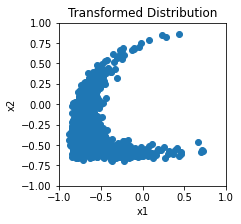

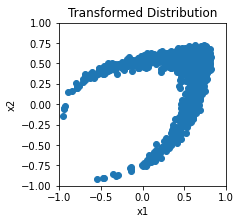

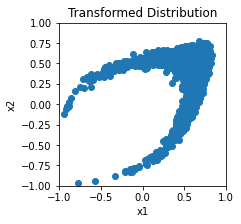

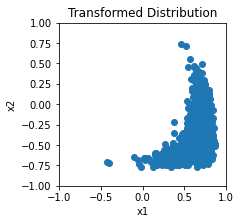

In [ ]:
# 4 plots of transformed distribution

for i in range(4):
  alpha, theta = get_alpha_theta()
  New_dist = get_Transformed_dist(alpha, theta)
  x = New_dist.sample(2000)
  display_scatter_plot(x)
  

### Create the image dataset
We will now use random normalising flows to generate an image dataset of contour plots. 


In [ ]:
# Function to compute transformed distribution densities

X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
inputs = np.transpose(np.stack((X, Y)), [1, 2, 0])

def get_densities(transformed_distribution):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """
    batch_shape = transformed_distribution.batch_shape
    Z = transformed_distribution.prob(np.expand_dims(inputs, 2))
    Z = np.transpose(Z, list(range(2, 2+len(batch_shape))) + [0, 1])
    return Z

In [ ]:
# Function to convert contour plots to numpy arrays

import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_image_array_from_density_values(Z):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """
    assert Z.shape == (100, 100)
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap='hot', levels=100)
    ax.axis('off')
    fig.tight_layout(pad=0)

    ax.margins(0)
    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image_from_plot

In [ ]:
# Function to get N images

def get_images_(N):
  images = []
  for i in range(N):
    alpha, theta = get_alpha_theta()
    New_dist = get_Transformed_dist(alpha, theta)
    Z = get_densities(New_dist)
    im = get_image_array_from_density_values(Z[0])
    images.append(im)

  return images  

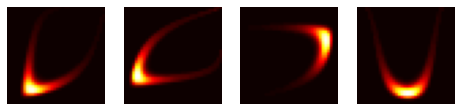

In [ ]:
# 4 contour plots of transformed distributions

images = get_images_(4)
plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(images[i])
  plt.axis('off')

In [ ]:
# Get 3000 images for our dataset

image_data = get_images_(3000)

In [ ]:
# Display image data shape

image_data = np.array(image_data)
print(image_data.shape)

(3000, 36, 36, 3)


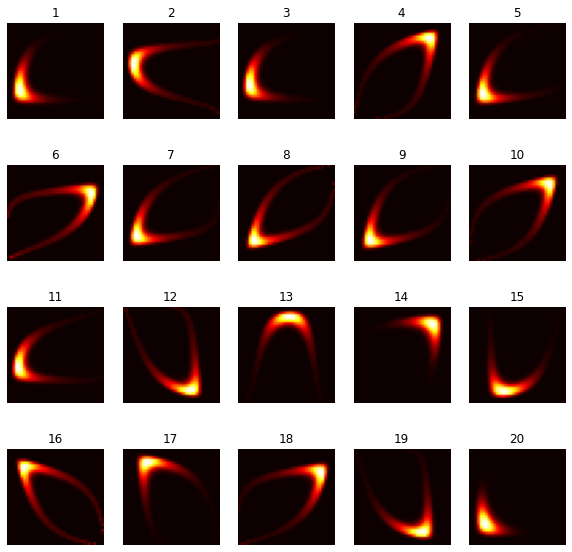

In [ ]:
# Display 20 images from the image data

seed_1 = random.sample(range(0,3000),20)
plt.figure(figsize=(10,10))
for i, v in enumerate(seed_1):
  plt.subplot(4,5,i+1)
  plt.imshow(image_data[v])
  plt.title(i+1)
  plt.axis('off')

We will now create the dataset that can be used to train a VAE.

In [ ]:
# Train and validation data split

train_images, val_images = train_test_split(image_data, test_size = 0.1)

In [ ]:
print(train_images.shape)
print(val_images.shape)

(2700, 36, 36, 3)
(300, 36, 36, 3)


In [ ]:
# Create train and validation datasets

train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
val_dataset = tf.data.Dataset.from_tensor_slices(val_images)

In [ ]:
# Function to scale images

def scale_images(image):
  return tf.cast(image, tf.float32)/255.0

In [ ]:
# Apply scale function to the datasets

train_dataset = train_dataset.map(scale_images)
val_dataset = val_dataset.map(scale_images)

In [ ]:
# Function to return a tuple

def return_tuple(image):
  return image, image

In [ ]:
# Apply tuple function to the datasets

train_dataset = train_dataset.map(return_tuple)
val_dataset = val_dataset.map(return_tuple)

In [ ]:
# Shuffle the datasets

train_dataset = train_dataset.shuffle(1000)

In [ ]:
# Batch the datasets

train_dataset = train_dataset.batch(20, drop_remainder=True)
val_dataset = val_dataset.batch(20, drop_remainder=True)

In [ ]:
print(train_dataset.element_spec)
print(val_dataset.element_spec)

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))
(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None), TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))


## Part-2 Variational Autoencoder
We will now create the encoder and decoder for the variational autoencoder algorithm. For the prior distribution we will use a zero-mean, isotropic Gaussian (identity covariance matrix).

In [ ]:
# Function to get prior

def get_prior(latent_dim):

  loc = tf.zeros(shape = (latent_dim,))
  prior = tfd.MultivariateNormalDiag(loc = loc)

  return prior


In [ ]:
# Function to get encoder

def get_encoder(latent_dim, prior_dist):
    
    encoder = Sequential([
        Conv2D(32, (4,4), activation = 'relu', strides = (2,2), padding = 'SAME', 
               input_shape = (36, 36, 3)),
        BatchNormalization(),
        Conv2D(64, (4,4), activation = 'relu', strides = (2,2), padding = 'SAME'),
        BatchNormalization(),
        Conv2D(256, (4,4), activation = 'relu', strides = (2,2), padding = 'SAME'),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim,
                                    activity_regularizer = tfpl.KLDivergenceRegularizer(prior_dist, 
                                                  weight = 1.0,
                                                  use_exact_kl = False, 
                                                  test_points_fn = lambda q: q.sample(3), 
                                                  test_points_reduce_axis = None))        
    ])
    
    return encoder

In [ ]:
# Function to get decoder

def get_decoder(latent_dim):
    
    decoder = Sequential([
        Dense(2304, activation = 'relu', input_shape = (latent_dim,)),
        Reshape((3,3,256)),
        UpSampling2D((2,2)),
        Conv2D(64, (3,3), activation = 'relu', padding = 'SAME'),
        UpSampling2D((2,2)),
        Conv2D(64, (3,3), activation = 'relu', padding = 'SAME'),
        UpSampling2D((2,2)),
        Conv2D(32, (3,3), activation = 'relu', padding = 'SAME'),
        UpSampling2D((2,2)),
        Conv2D(3, (3,3), padding = 'SAME'),
        Flatten(),
        Dense(tfpl.IndependentBernoulli.params_size(event_shape = (36, 36, 3))),
        tfpl.IndependentBernoulli(event_shape = (36, 36, 3))
    ])
    
    return decoder

In [ ]:
# Latent Dimension

latent_dim = 2

In [ ]:
# Encoder summary

prior_dist = get_prior(latent_dim)

encoder = get_encoder(latent_dim, prior_dist)

encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 32)        1568      
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 256)         262400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0

In [ ]:
# Decoder summary

decoder = get_decoder(latent_dim)

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2304)              6912      
_________________________________________________________________
reshape (Reshape)            (None, 3, 3, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 64)          147520    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 24, 24, 64)       

We now build and train the VAE.

In [ ]:
# Create VAE model

VAE = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [ ]:
# VAE summary

VAE.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 36, 36, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 18, 32)        1568      
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 256)         262400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 5, 256)         1024  

In [ ]:
# Loss function

def reconstruction_loss(batch_of_images, decoding_dist):
    
    return tf.reduce_mean(-decoding_dist.log_prob(batch_of_images))

In [ ]:
# Define optimizer and compile 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
VAE.compile(optimizer=optimizer, loss=reconstruction_loss)

In [ ]:
# Train the VAE model

history = VAE.fit(train_dataset, validation_data = val_dataset, epochs=30, verbose = True)

Epoch 1/30
135/135 [==============================] - 35s 17ms/step - loss: 648.5843 - val_loss: 797.1068
Epoch 2/30
135/135 [==============================] - 2s 14ms/step - loss: 454.6977 - val_loss: 584.3962
Epoch 3/30
135/135 [==============================] - 2s 14ms/step - loss: 421.2172 - val_loss: 453.0264
Epoch 4/30
135/135 [==============================] - 2s 14ms/step - loss: 410.1721 - val_loss: 407.5817
Epoch 5/30
135/135 [==============================] - 2s 14ms/step - loss: 404.2760 - val_loss: 402.9222
Epoch 6/30
135/135 [==============================] - 2s 14ms/step - loss: 401.8610 - val_loss: 395.0323
Epoch 7/30
135/135 [==============================] - 2s 14ms/step - loss: 399.7413 - val_loss: 404.0718
Epoch 8/30
135/135 [==============================] - 2s 14ms/step - loss: 399.6026 - val_loss: 400.5317
Epoch 9/30
135/135 [==============================] - 2s 14ms/step - loss: 398.7100 - val_loss: 392.4062
Epoch 10/30
135/135 [==============================] -

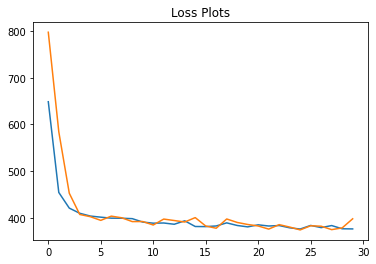

In [ ]:
# Plot loss vs epochs

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss Plots")

plt.show()

We will now pass in some images to encoder block and get reconstructed images out of the decoder.

In [ ]:
# Randomly select 1000 images from our 3000 image dataset

seed_2 = random.sample(range(0,3000),1000)

In [ ]:
# Obtain the embeddings for 1000 images

embeddings = encoder(tf.cast(image_data[seed_2] ,tf.float32)/255.0).mean()

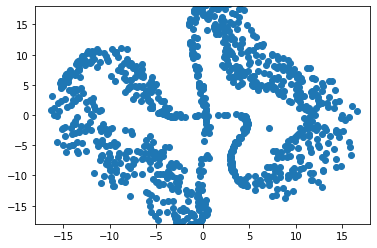

In [ ]:
# Plot the embeddings

x = embeddings[...,0]
y = embeddings[...,1]
plt.scatter(x,y)
plt.xlim(-18,18)
plt.ylim(-18,18)
plt.show()

In [ ]:
# Randomly select 4 images from the dataset

seed_3 = random.sample(range(0,3000),4)

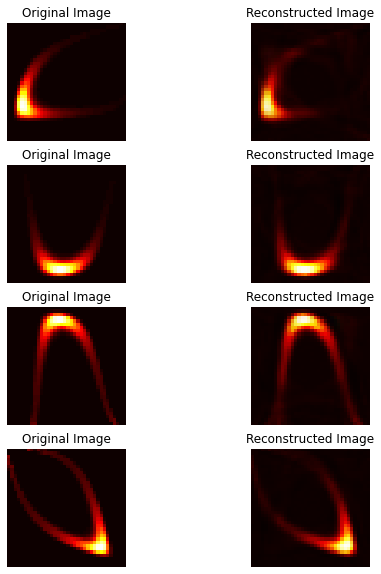

In [ ]:
# Plot the original image and the reconstructed image

plt.figure(figsize=(8,10))
for i, v in enumerate(seed_3):
  plt.subplot(4,2,2*i+1)
  plt.imshow(image_data[v])
  plt.title('Original Image')
  plt.axis('off')

  im = tf.expand_dims(image_data[v],0)
  im = tf.cast(im, tf.float32)/255.
  r_im = tf.squeeze(VAE(im).mean())
  plt.subplot(4,2,2*i+2)
  plt.imshow(r_im)
  plt.title('Reconstructed Image')
  plt.axis('off')

We could also generate some images from the decoder by directly sampling the latent space.

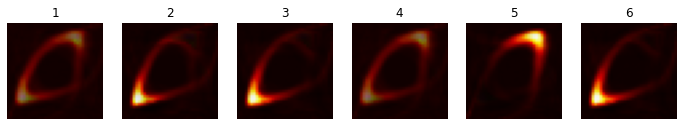

In [ ]:
# Sample embeddings from prior distribution and generate images by decoding the embeddings

embeddings_from_prior = prior_dist.sample(6)
new_images = decoder(embeddings_from_prior).mean()

plt.figure(figsize=(12,8))
for i in range(6):
  plt.subplot(1,6,i+1)
  plt.imshow(new_images[i])
  plt.axis('off')
  plt.title(i+1)

In [ ]:
# Sample embeddings randomly within a box of z_1 ~ (-15,15) and z_2 ~ (-15,15)

uniform_embedding = tfd.Uniform(low=-15.0, high=15.0)
random_embeddings_1 = tf.expand_dims(uniform_embedding.sample(6), axis = -1)
random_embeddings_2 = tf.expand_dims(uniform_embedding.sample(6), axis = -1)
random_embeddings = tf.concat([random_embeddings_1, random_embeddings_2], axis = -1)
print(random_embeddings.numpy())

[[  9.674681    3.7779121]
 [  2.9135303  -9.2930355]
 [ -3.3703995  -6.5364647]
 [ -1.1851139 -11.60109  ]
 [ -7.338352   -7.6572027]
 [ -6.6432743   7.7196083]]


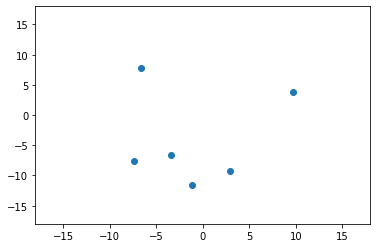

In [ ]:
# Plot the embeddings

plt.scatter(random_embeddings_1, random_embeddings_2)
plt.xlim(-18,18)
plt.ylim(-18,18)
plt.show()

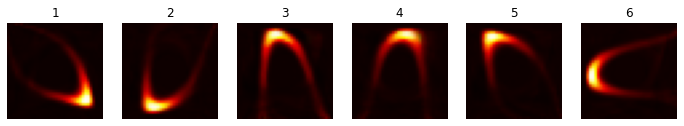

In [ ]:
# Decode the embeddings and get the corresponding contour plots

new_images = decoder(random_embeddings).mean()

plt.figure(figsize=(12,8))
for i in range(6):
  plt.subplot(1,6,i+1)
  plt.imshow(new_images[i])
  plt.axis('off')
  plt.title(i+1)

### Make a video of latent space interpolation
Just for fun, the below code generates a video of a point in the latent space and the corresponding generated image from the decoder.

In [ ]:
# Function to create animation

import matplotlib.animation as anim
from IPython.display import HTML


def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    fig = plt.figure(figsize=(9, 4))  
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-18, 18])
    ax1.set_ylim([-18, 18])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(True)
    ax1.axes.get_yaxis().set_visible(True)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable 
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(17 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i): 
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length, 
                              repeat=False, blit=True, interval=150)

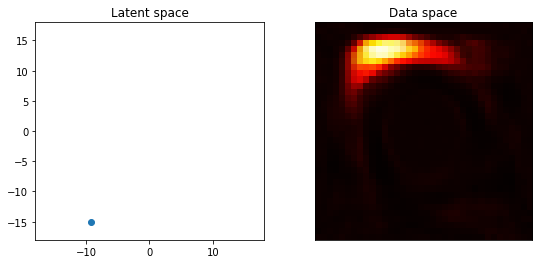

In [ ]:
# Create the animation
latent_size = latent_dim
a = get_animation(latent_size, decoder, interpolation_length=200)
HTML(a.to_html5_video())

Ain't it a beauty!